In [17]:
import sys, os, re, csv, codecs,gc, time, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers



In [18]:
train = pd.read_csv("C:\\SpringBoard\\CapstoneOne\\RedditSen.csv", encoding='utf-8')

In [19]:
train.head()

,Unnamed: 0,comment,positive,negative,compund,positive_comment,negative_comment,neutral_comment
0,0,"""You must post a clear and direct question in ...",0.090,0.052,0.1531,1,0,0
1,1,I have learned English.,0.000,0.000,0.0000,0,0,1
2,2,How to bunny hop,0.000,0.000,0.0000,0,0,1
3,3,"""You laugh, but have you ever realized you wal...",0.099,0.000,0.3182,1,0,0
4,4,After getting shot I can heal myself by drinki...,0.189,0.000,0.2732,1,0,0


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7811 entries, 0 to 7810
Data columns (total 8 columns):
Unnamed: 0          7811 non-null int64
comment             6887 non-null object
positive            7811 non-null float64
negative            7811 non-null float64
compund             7811 non-null float64
positive_comment    7811 non-null int64
negative_comment    7811 non-null int64
neutral_comment     7811 non-null int64
dtypes: float64(3), int64(4), object(1)
memory usage: 488.3+ KB


In [21]:
train.isnull().any()

Unnamed: 0          False
comment              True
positive            False
negative            False
compund             False
positive_comment    False
negative_comment    False
neutral_comment     False
dtype: bool

In [33]:
#Split into X and Y sets
comment_class = ["positive_comment","negative_comment","neutral_comment"]
x = train["comment"].fillna("fillna").values
y = train[comment_class].values


In [23]:
#Tokenize data breaking sentence into individual words
#Index words into a dictionary and assign index values for each
#Represent index as a series of numbers and plug into LSTM model
max_features = 150
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x))
tokenized_train = tokenizer.texts_to_sequences(x)

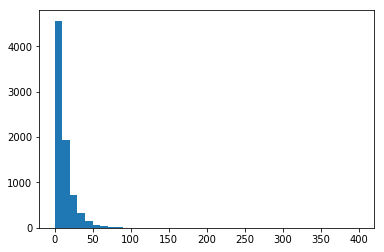

In [24]:
#Pad data by viewing the distribution of words in sentences
totalwordnum = [len(one_comment) for one_comment in tokenized_train]
plt.hist(totalwordnum,bins=np.arange(0,410,10))
plt.show()

In [25]:
#Pad the data to make it all same length
#set maxlen to 300 because 300 seems to be the tail end of the data
maxlen = 150
X_t = pad_sequences(tokenized_train, maxlen=maxlen)

In [28]:
#Embed the layer
inp = Input(shape=(maxlen, ))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)


Reshape{3}.0


We have to pass the output to a normal layer by reshaping the 3D tensor into a 2D one by using a Global Max Pooling layer which is used to reduce the dimensions of larger image data. This is done by taking the Max values of each patch of data, these max values will now be a new down-sized set of data usable by 2D tensor flow.

In [13]:
#Fit X into tensor flow model
x = LSTM(60, return_sequences=True,name='lstm')(x)
#Flatten into 2D
x = GlobalMaxPool1D()(x)
#Drop 10% of nodes
x = Dropout(0.1)(x)
#Pass output of dropout layer to a denser connected layer
#and a RELU function
x = Dense(50, activation="relu")(x)
#feed output into a dropout laer again
x = Dropout(.1)(x)
#feed output into a sigmoid layer because we want a binary class.
#for each of the three labels. Sigmoids have a output between (0,1)
x = Dense(6, activation="sigmoid")(x)

In [29]:
#Define inputs and outputs of learning process. 
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])